In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random
import time
import numpy as np
import seaborn as sns

In [270]:
class board:
    
    wMoved = {'l':False,'r':False, 'K':False}
    bMoved = {'l':False,'r':False, 'K':False}
    
    files = ['a','b','c','d','e','f','g','h']
    ranks = [1,2,3,4,5,6,7,8]
    moveDict = {'upx':('up','x'),
               'downx':('down','x'),
               'leftx':('left','x'),
               'rightx':('right','x'),
               'upxleftx':(('up','x'),('left','x'),2),
               'upxrightx':(('up','x'),('right','x'),2),
               'downxleftx':(('down','x'),('left','x'),2),
               'downxrightx':(('down','x'),('right','x'),2),
               'up1':('up',1),
               'down1':('down',1),
               'left1':('left',1),
               'right1':('right',1),
               'up1left1':(('up',1),('left',1),2),
               'up1right1':(('up',1),('right',1),2),
               'down1left1':(('down',1),('left',1),2),
               'down1right1':(('down',1),('right',1),2),
               'up2left':(('up',2),('left',1),2),
               'up2right':(('up',2),('right',1),2),
               'left2up':(('left',2),('up',1),2),
               'left2down':(('left',2),('down',1),2),
               'right2up':(('right',2),('up',1),2),
               'right2down':(('right',2),('down',1),2),
               'down2left':(('down',2),('left',1),2),
               'down2right':(('down',2),('right',1),2),
               'up2':('up',2),
                'down2':('down',2),
               'WpTakeL':(('up',1),('left',1),2),
               'WpTakeR':(('up',1),('right',1),2),
               'BpTakeL':(('down',1),('left',1),2),
               'BpTakeR':(('down',1),('right',1),2),
               'castleR': ('right',2),
               'castleL': ('left',2)}
    
    def __init__(self, read=False, copyFrom=False, copySource=False, imaginary=False):
        #creates a board as a DataFrame or clones an existing board
        if imaginary or copyFrom:
            self.body = copySource.copy()
        else:
            self.body = pd.read_csv(read, index_col=0)
            
    def recon(self, rsquare):
        #look at a square and return the piece ID or False
        if not rsquare:
            return False
        if rsquare == '0':
            return False
        #print('recon rsquare: ' + str(rsquare))
        file = rsquare[0]
        rank = rsquare[1]
        square = self.body.at[rank,file]
        #print('recon square: ' + str(square))
        return square
            
    def walk(self, square, movement):
        if not square:
            return False
        file = square[0]
        rank = square[1]
        direction = movement[0]
        steps = movement[1]
        if steps == 'x':
            steps = 1
        #print(steps)
        fileCom = {"up":1, "down":-1, "left":-1, "right":1}
        global newPos
        if direction in ["left", "right"]:
            findex = board.files.index(file)
            nindex = findex + (steps * fileCom[direction])
            if nindex not in range(0,8):
                return False
            newFile = board.files[nindex]
            newPos = (newFile, rank)
        if direction in ["up", "down"]:
            newRank = (rank + (steps * fileCom[direction]))
            if newRank not in range(1,9):
                return False
            newPos = (file, newRank)
        return newPos
    
    def movePiece(self, square, newSquare):
        self.body.at[newSquare[1], newSquare[0]] = b1.body.at[square[1], square[0]]
        self.body.at[square[1], square[0]] = '0'
    
    def assessSquare(self, square, newSquare, origin):
        #print('ASSESSSQUARE')
        check = self.recon(newSquare)
        if not check:
            #out of bounds
            #print('oob')
            return 'oob'
        elif check == '0':
            #then the square is empty
            #print('empty')
            return 'empty'
        else:
            #the square is either friend or foe
            #print(recon(newSquare))
            #print(recon(square))
            if self.recon(newSquare)[0] is not self.recon(origin)[0]:
                #print('foe')
                return 'foe'
            else:
                #print('friend')
                return 'friend'
    
    def xCheck(self, x, move, square, imaginary=False):
        origin = square
        xSquares = []
        #look through each move str name, make moves and report if possible
        if 'x' in move:
            #print(move + ': x')
            #need to test further moves in this direction until blocked
            blocked = False
            #xSquares = []
            while not blocked:
                #print('not blocked')
                if len(x) == 3:
                    #move is a two-step
                    move1 = x[0]
                    #print(move1)
                    move2 = x[1]
                    #print(move2)
                    newSquare = self.walk(square, move1)
                    #print(newSquare)
                    newSquare = self.walk(newSquare, move2)
                    #print(newSquare)
                else:
                    #move is a one-step
                    newSquare = self.walk(square, x)
                    #print(newSquare)

                result = self.assessSquare(square, newSquare, origin)
                #print(result)
                if result == 'oob':
                    blocked = True
                    newSquare = False
                elif result == 'empty':
                    blocked = False
                    xSquares.append(newSquare)
                    square = newSquare
                elif result == 'friend':
                    blocked = True
                    newSquare = False
                else:
                    blocked = True
                    xSquares.append(newSquare)
                    square = newSquare
            newSquare = xSquares
            if len(newSquare) == 0:
                newSquare = False

        if 'x' not in move:
            #print(move + ': no x')
            #move only specified number of moves

            #only for castle
            if 'castle' in move:
                if 'L' in move:
                    team = 'l'
                if'R' in move:
                    team = 'r'

            #non-castle
            if len(x) == 3:
                #print(x)
                #move is a two-step
                #this is where the horses move
                move1 = x[0]
                #print(move1)
                move2 = x[1]
                #print(move2)
                newSquare = self.walk(square, move1)
                newSquare = self.walk(newSquare, move2)
            else:
                #move is a one-step
                newSquare = self.walk(square, x)
            result = self.assessSquare(square, newSquare, origin)
            if result == 'oob':
                newSquare = False
            elif result == 'friend':
                if not imaginary:
                    newSquare = False
            if 'P' in self.recon(square):
                if newSquare:
                    if not imaginary:
                        if newSquare[0] is not square[0]:
                            #if newSquare is in different file
                            if self.recon(newSquare) == '0':
                                #if newSquare is empty
                                newSquare = False
                        elif newSquare[0] is square[0]:
                            #if newSquare is in same file
                            if self.recon(newSquare) != '0':
                                #if newSquare is empty
                                newSquare = False
                    elif imaginary:
                        if newSquare[0] is square[0]:
                            #same file
                            #if self.recon(newSquare) != '0':
                                #not empty
                            newSquare = False
            if newSquare:
                xSquares.append(newSquare)
        return xSquares
    
    def moveTester(self, square, castle=True, imaginary=False):
        #returns legal moves
        #print('MOVETESTER')
        legalmoves = {}
        if self.recon(square) == '0':
            return False
        moves = self.defaultMoves(square, castle=castle)
        #print(moves)
        for move in moves:
            x = board.moveDict[move]
            #print(move)
            #print(x)
            newSquare = self.xCheck(x, move, square, imaginary)
            legalmoves[move] = newSquare

        #returns a dict of moves and their resulting squares (or False)
        return legalmoves
    
    def moveCounter(self, square, castle=True, imaginary=False):
        #print('MOVECOUNTER')
        #returns count of legal moves
        count = 0
        movesReturned = self.moveTester(square, castle=castle, imaginary=imaginary)
        #print(movesReturned)
        if movesReturned:
            for move in movesReturned.values():
                if move:
                    count += len(move)
        return count
    
    def myTeam(self, color, castle=True, imaginary=False):
        #global board
        #print('MYTEAM')
        #team is w or b (str)
        myPieces = {}
        for rank in board.ranks:
            for file in board.files:
                piece = self.body.at[rank,file]
                #print(piece)
                if color in piece:
                    movenum = self.moveCounter((file,rank), castle, imaginary)
                    myPieces[piece + str(file) + str(rank)] = ((file, rank), movenum)
        return myPieces
    
    def myMoves(self, teamdict):
        #print('MYMOVES')
        moves = {}
        for piece in teamdict:
            x = teamdict[piece]
            if x[1] != 0:
                moves[piece] = x
        return moves
    
    ### need a function that generates a long
    
    def pickRandomMove(self, team, castle=True, specific=False):
        canmoves = []
        x = self.myMoves(self.myTeam(team))
        if len(x) == 0:
            return 'done', 'done'
        #print(x)
        while len(canmoves) == 0:
            if specific:
                pick = specific
            if not specific:
                pick = random.choice(list(x))
            #print('pick: ' + str(pick))
            square = x[pick][0]
            moves = self.moveTester(square, castle)
            #print(moves)
            for y in list(moves):
                if moves[y]:
                    canmoves.append(y)
        #print(canmoves)    
        movepick = random.choice(canmoves)
        return pick, movepick
    
    def dangerDetector(self, square, team, imaginary=False):
        attacks = []
        enemy = False
        if team == 'w':
            enemy = 'b'
        if team == 'b':
            enemy = 'w'
        if not enemy:
            return False
        for rank in board.ranks:
            for file in board.files:
                if enemy in self.recon((file,rank)):
                    #print('enemy: ' + str(recon((file,rank))) + str(file) + str(rank))
                    moves = self.moveTester((file,rank), imaginary=imaginary)
                    #print(moves)
                    for move in moves.values():
                        if move:
                            #print('square: ' + str(square))
                            #print('move: ' + str(move))
                            if str(square) in str(move):
                                loc = (file,rank)
                                attacks.append(str(self.recon(loc)) + str(file) + str(rank))
        if len(attacks) == 0:
            return False
        return attacks
    
    def canCastle(self, team, side):
        #check for danger or teammate along king path
        dangers = 0
        if team == 'w':
            if not board.wMoved[side] or not board.wMoved['K']:
                return False
            if side == 'l':
                #king is at ('e',1), rook is at ('a',1)
                #king goes to ('c',1) and left rook goes to ('d',1)
                #e1 thru c1 must not be in danger
                path = [('e',1),('d',1),('c',1)]

            if side == 'r':
                #king is at ('e',1), rook is at ('h',1)
                #king goes to ('g',1) and right rook goes to ('f',1)
                #e1 thru g1 must not be in danger
                path = [('e',1),('f',1),('g',1)]

        if team == 'b':
            if not board.bMoved[side] or not board.bMoved['K']:
                return False
            if side == 'l':
                #king is at ('e',8), rook is at ('a',8)
                #king goes to ('c',8) and left rook goes to ('d',8)
                #e8 thru c8 must not be in danger
                path = [('e',8),('d',8),('c',8)]

            if side == 'r':
                #king is at ('e',8), rook is at ('h',8)
                #king goes to ('g',8) and rook goes to ('f',8)
                #e8 thru g8 must not be in danger
                path = [('e',8),('f',8),('g',8)]
        for spot in path:
            piece = self.recon(spot)
            if 'K' not in piece:
                if '0' not in piece:
                    dangers += 1
                if '0' in piece:
                    x = self.dangerDetector((spot), team)
                    if x:
                        dangers += len(x)
            #print(dangers)
        if dangers == 0:
            return True
        else:
            return False
        
    def castle(self, team, side):
        #global board
        if team == 'w':
            if side == 'l':
                #king is at ('e',1), rook is at ('a',1)
                #king goes to ('c',1) and left rook goes to ('d',1)
                kingfrom = ('e',1)
                kingto = ('c',1)
                rookfrom = ('a',1)
                rookto = ('d',1)
                return 'white queen side castle'

            if side == 'r':
                #king is at ('e',1), rook is at ('h',1)
                #king goes to ('g',1) and right rook goes to ('f',1)
                kingfrom = ('e',1)
                kingto = ('g',1)
                rookfrom = ('h',1)
                rookto = ('f',1)
                return 'white king side castle'

        if team == 'b':
            if side == 'l':
                #king is at ('e',8), rook is at ('a',8)
                #king goes to ('c',8) and left rook goes to ('d',8)
                kingfrom = ('e',8)
                kingto = ('c',8)
                rookfrom = ('a',8)
                rookto = ('d',8)
                return 'black queen side castle'

            if side == 'r':
                #king is at ('e',8), rook is at ('h',8)
                #king goes to ('g',8) and rook goes to ('f',8)
                kingfrom = ('e',8)
                kingto = ('g',8)
                rookfrom = ('h',8)
                rookto = ('f',8)
                return 'black king side castle'
    
        ### move king ###
        self.body.at[kingto[1],kingto[0]] = self.body.at[kingfrom[1],kingfrom[0]]
        self.body.at[kingfrom[1],kingfrom[0]] = '0'
        #################
        ### move rook ###
        self.body.at[rookto[1],rookto[0]] = self.body.at[rookfrom[1],rookfrom[0]]
        self.body.at[rookfrom[1],rookfrom[0]] = '0'
        #################
        #return self.body

    def defaultMoves(self, square, castle=True):
        moves = []
        #print('DEFAULTMOVES')
        #returns default moveset for a piece
        file = square[0]
        rank = square[1]
        piece = self.recon(square)
        if piece == '0':
            return False
        color = piece[0]
        #print(color)
        pieceType = piece[1]
        #print(pieceType)
        if pieceType == 'P':
            #check pawn team and loc
            if color == 'w':
                moves = ['up1','WpTakeL','WpTakeR']
                if rank == 2:
                    #pawn can move up 1 or 2
                    moves = ['up1','up2','WpTakeL','WpTakeR']
            if color == 'b':
                moves = ['down1','BpTakeL','BpTakeR']
                if rank == 7:
                    #pawn can move down 1 or 2
                    moves = ['down1','down2','BpTakeL','BpTakeR']
        if pieceType == 'R':
            moves = ['upx','downx','leftx','rightx']
        if pieceType == 'N':
            moves = ['up2left','up2right','left2up','left2down','right2up','right2down','down2left','down2right']
        if pieceType == 'B':
            moves = ['upxleftx','upxrightx','downxleftx','downxrightx']
        if pieceType == 'Q':
            moves = ['upx','downx','leftx','rightx','upxleftx','upxrightx','downxleftx','downxrightx']
        if pieceType == 'K':
            if not castle:
                moves = ['up1','down1','left1','right1','up1left1','up1right1','down1left1','down1right1']
            if castle:
                left = self.canCastle(color, 'l')
                right = self.canCastle(color,'r')
                moves = ['up1','down1','left1','right1','up1left1','up1right1','down1left1','down1right1']
                if left:
                    moves.append('castleL')
                if right:
                    moves.append('castleR')
        return moves
    
    def promote(self, team, square):
        #global board
        options = ['Q', 'R', 'B', 'N']
        promotion = random.choice(options)
        newPiece = str(team) + promotion
        self.body.at[square[1],square[0]] = newPiece
        return (str(team) + 'P' + str(square[0]) + str(square[1]) + ' promoted to ' + promotion)
        #print(newPiece)
        
    def heatView(self, getSum=False):
        #https://stackoverflow.com/questions/63367517/how-to-convert-object-to-int-or-float-in-pandas
        #thanks, dad
        
        #king cannot count towards defending a square that would put it in check
        #pieces cannot count towards defending a square that would put king in check
        claim = board(imaginary=True, copySource=self.body)
        teamB = self.myTeam('b', imaginary=True)
        teamW = self.myTeam('w', imaginary=True)
        #print(teamB.values())

        for file in claim.files:
            for rank in claim.ranks:
                x = self.body.at[rank,file]
                if x != 0:
                    claim.body.at[rank,file] = 0
                    #print(x)
                    if 'w' in x:
                        claim.body.at[rank,file] -= 1
                    if 'b' in x:
                        claim.body.at[rank,file] += 1

        locsB = []
        locsW = []
        targetsB = []
        targetsW = []
        for loc in teamB.values():
                #print(loc[0])
                locsB.append(loc)
        for loc in teamW.values():
                #print(loc[0])
                locsW.append(loc)

        for spot in locsB:
            #use moveTester values as claims
            #print(spot[0])
            #print(square)
            claims = self.moveTester(spot[0], imaginary=True)
            #print(claims)
            #print(claims.values())
            for target in claims.values():
                targetsB += target
        #print(targets)
        print('targets: ' + str(len(targetsB)))
        for spot in locsW:
            #use moveTester values as claims
            #print(spot[0])
            #print(square)
            claims = self.moveTester(spot[0], imaginary=True)
            #print(claims)
            #print(claims.values())
            for target in claims.values():
                targetsW += target
        #print(targets)
        print('targets: ' + str(len(targetsW)))

        for b in targetsB:
            #value = game.body.at[x[1], x[0]]
            #print(value)
            claim.body.at[b[1], b[0]] += 1

        for w in targetsW:
            #value = game.body.at[x[1], x[0]]
            #print(value)
            claim.body.at[w[1], w[0]] -= 1

        x = claim.body.copy()
        x = x.apply(pd.to_numeric,errors='ignore')
        if not getSum:
            return sns.heatmap(x, cmap='binary', annot=True)
        else:
            return x.to_numpy().sum()
        
    def TmoveCount(self, turn):
        moveBook = self.myTeam(turn)
        moves = 0

        for moveNum in moveBook.values():
            moves += moveNum[1]
        
        return moves
    
    def VirtualMove(self):
        totalMoves = game.TmoveCount(turn)
        badMoves = []
        go=True
        while go:
            ### look at team ###
            Vgame = board(copySource=self.body, copyFrom=True)
            team = Vgame.myTeam(turn)

            ### pick a random piece and move ###

            piece, move = Vgame.pickRandomMove(turn)
            moveStr = piece + str(move)
            #print(moveStr)

            moveDict = Vgame.moveTester((str(piece[2]), int(piece[3])))

            ### this is the place we're gonna move
            dest = random.choice(moveDict[move])

            if 'P' in piece:
                pawn = True
            else:
                pawn = False

            ### MOVEMENT ################################

            if 'castle' not in move:
                ### prepare the start and end positions ###
                square = team[piece][0]
                start = square
                #('d', 3)
                end = dest
                #('d', 4)

                ### detects if 'takes' needs to be said instead of 'to' ###
                if Vgame.assessSquare(start, end, start) == 'foe':
                    totake = ' takes '
                    endpiece = str(Vgame.recon(end))
                else:
                    totake = ' to '
                    endpiece = ''
                #print(Vgame.recon(start))
                #print(start)
                #print(end)
                statement = (str(Vgame.recon(start)) + str(start[0]) + str(start[1]) + str(totake) + str(endpiece) + str(end[0]) + str(end[1]))

                Vgame.body.at[end[1], end[0]] = Vgame.body.at[start[1], start[0]]
                Vgame.body.at[start[1], start[0]] = '0'


            ### EXTRAS ####################################

            if 'castle' in move:
                if 'L' in move:
                    statement = turn + ' queen side castle'
                    side = 'l'
                if 'R' in move:
                    statement = turn + ' king side castle'
                    side = 'r'
                Vgame.castle(turn, side)


                if team == 'w':
                    Vgame.wRmoved[side] = True
                    Vgame.wKmoved = True
                if team == 'b':
                    Vgame.BRmoved[side] = True
                    Vgame.BKmoved = True

            if pawn:
                if turn == 'w':
                    if end[1] == 8:
                        statement = Vgame.promote(turn, end)
                if turn == 'b':
                    if end[1] == 1:
                        statement = Vgame.promote(turn, end)

            ### SAFETY CHECK ##################################


            team = Vgame.myTeam(turn)

            #print('testing ' + statement)

            for piece in team.keys():
                #print(piece)
                if 'K' in piece:
                    #print('found king')
                    kingDanger = Vgame.dangerDetector(team[piece][0], turn)

            if not kingDanger:
                #print(moveStr + ' worked, king is out of danger')
                self.body = Vgame.body
                go = False
                status = True

            if kingDanger:
                #print(moveStr + ' did not work, king in danger')
                if statement not in badMoves:
                    badMoves.append(statement)
                    #print(badMoves)
                    #print(len(badMoves))
                    #print(totalMoves)
                    #print(team)
                if len(badMoves) == totalMoves:
                    go=False
                    status = False
        return status, statement, start, end

    def ManualMove(self):
        

In [271]:
game = board("chess board castletest.csv")

# in checktest bQf5 should have 18 moves

Idea: a parallel chess board with values indicating a level of certainty that this team controls the square

In [193]:
game.body

,a,b,c,d,e,f,g,h
8,bR,bN,bB,bQ,bK,bB,bN,bR
7,bP,bP,bP,bP,bP,bP,bP,bP
6,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0
2,wP,wP,wP,wP,wP,wP,wP,wP
1,wR,wN,wB,wQ,wK,0,0,wR


targets: 25
targets: 24


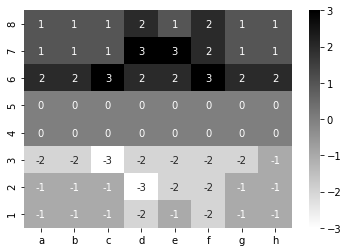

In [5]:
game.heatView()

In [6]:
game.myTeam('b', imaginary=True)

### THESE MOVES ALL BLOCK THE WHITE KING FROM SQUARES ###

{'bPa7': (('a', 7), 1),
 'bPb7': (('b', 7), 2),
 'bPc7': (('c', 7), 2),
 'bPd7': (('d', 7), 2),
 'bPe7': (('e', 7), 2),
 'bPf7': (('f', 7), 2),
 'bPg7': (('g', 7), 2),
 'bPh7': (('h', 7), 1),
 'bRa8': (('a', 8), 0),
 'bNb8': (('b', 8), 3),
 'bBc8': (('c', 8), 0),
 'bQd8': (('d', 8), 0),
 'bKe8': (('e', 8), 5),
 'bBf8': (('f', 8), 0),
 'bNg8': (('g', 8), 3),
 'bRh8': (('h', 8), 0)}

In [7]:
game.moveCounter(('e',8))

0

In [8]:
game.moveTester(('f',6))

False

In [9]:
game.myTeam('w')

{'wRa1': (('a', 1), 0),
 'wNb1': (('b', 1), 2),
 'wBc1': (('c', 1), 0),
 'wQd1': (('d', 1), 0),
 'wKe1': (('e', 1), 1),
 'wRh1': (('h', 1), 2),
 'wPa2': (('a', 2), 2),
 'wPb2': (('b', 2), 2),
 'wPc2': (('c', 2), 2),
 'wPd2': (('d', 2), 2),
 'wPe2': (('e', 2), 2),
 'wPf2': (('f', 2), 2),
 'wPg2': (('g', 2), 2),
 'wPh2': (('h', 2), 2)}

In [10]:
game.canCastle('w', 'r')

False

In [11]:
game.body

,a,b,c,d,e,f,g,h
8,bR,bN,bB,bQ,bK,bB,bN,bR
7,bP,bP,bP,bP,bP,bP,bP,bP
6,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0
2,wP,wP,wP,wP,wP,wP,wP,wP
1,wR,wN,wB,wQ,wK,0,0,wR


In [12]:
game.pickRandomMove('w')

('wKe1', 'right1')

In [13]:
game.walk(('e',2), ('up',3))

('e', 5)

In [14]:
game.recon(('e',2))

'wP'

In [15]:
game.promote('w', ('h',2))

'wPh2 promoted to N'

In [16]:
game.myTeam('w')

{'wRa1': (('a', 1), 0),
 'wNb1': (('b', 1), 2),
 'wBc1': (('c', 1), 0),
 'wQd1': (('d', 1), 0),
 'wKe1': (('e', 1), 1),
 'wRh1': (('h', 1), 2),
 'wPa2': (('a', 2), 2),
 'wPb2': (('b', 2), 2),
 'wPc2': (('c', 2), 2),
 'wPd2': (('d', 2), 2),
 'wPe2': (('e', 2), 2),
 'wPf2': (('f', 2), 2),
 'wPg2': (('g', 2), 2),
 'wNh2': (('h', 2), 3)}

In [272]:
def play(steps=False, resetBoard=False):
    global turn
    global game
    global Vgame
    global wMoved
    global bMmoved
    wMoved = {'l':False,'r':False, 'K':False}
    bMoved = {'l':False,'r':False, 'K':False}
    count = 0
    over = False
    if resetBoard:
        game = board("chess board.csv")
        turn = 'w'
    if steps:
        step = 0
    checkmate=False
    
###### MAIN GAME LOOP ##################################
    
    while True:
        Vgame = board(copySource=game.body, copyFrom=True)
        totalMoves = game.TmoveCount(turn)
        badMoves = []
        go=True
        team = Vgame.myTeam(turn)
        
        ### VIRTUAL MOVE LOOP ###########################
        
        status, statement, start, end = game.VirtualMove()    
            
        if not status:
            if turn == 'w':
                winner = 'b'
            if turn == 'b':
                winner = 'w'
            print('checkmate, ' + winner + ' wins!')
            break
                        
            ###check if king is safe before making move permanent
        
        print(statement)
                    
        ### this chunk keeps track of stuff necessary for castling ###
        if game.recon(start) == 'wK':
            game.wMoved['K'] = True
        if game.recon(start) == 'bK':
            game.bMoved['K'] = True
        if game.recon(start) == 'wR':
            if start == ('a',1):
                game.wMoved['l'] = True
            if start == ('h',1):
                game.wMoved['r'] = True
        if game.recon(start) == 'bR':
            if start == ('a',8):
                game.bMoved['l'] = True
            if start == ('h',8):
                game.bMoved['r'] = True
        

        q = 0
        if turn == 'b':
            turn = 'w'
            q = 1
        if turn == 'w' and q == 0:
            turn = 'b'
        
        wPieces = game.myTeam('w')
        bPieces = game.myTeam('b')

        if len(wPieces) == 1 and len(bPieces) == 1:
            return('stalemate after {} moves'.format(step))
            
        #print(board)
        count += 1
        if steps:
            step += 1
            if step == steps:
                return 'paused after ' +  str(step) + ' moves'
        #time.sleep(0.5)
        

In [276]:
play(2000, resetBoard=True)

wPb2 to b4
bPh7 to h5
wPe2 to e4
bPb7 to b6
wPh2 to h4
bNg8 to f6
wNb1 to a3
bPb6 to b5
wRa1 to b1
bPe7 to e5
wPa2 to a4
bRh8 to h6
wBf1 takes bPb5
bBc8 to a6
wNa3 to c4
bKe8 to e7
wRb1 to a1
bPa7 to a5
wPg2 to g3
bPd7 to d5
wPc2 to c3
bPg7 to g6
wPf2 to f4
bPd5 takes wNc4
wPb4 takes bPa5
bQd8 to c8
wRh1 to h3
bPg6 to g5
wPf4 takes bPg5
bBf8 to g7
wQd1 takes bPh5
bRh6 to g6
wKe1 to f2
bRg6 to h6
wKf2 to f3
bBa6 takes wBb5
wPd2 to d4
bPf7 to f5
wPa4 takes bBb5
bBg7 to f8
wPg3 to g4
bPe5 takes wPd4
wRh3 to h2
bPc7 to c5
wRh2 to f2
bRa8 to a6
wBc1 to f4
bRa6 to d6
wKf3 to g3
bPd4 to d3
wNg1 to e2
bBf8 to g7
wPg5 to g6
bQc8 to e6
wNe2 to c1
bKe7 to d7
wPb5 to b6
bRd6 takes wPb6
wRf2 to d2
bKd7 to c6
wNc1 to a2
bNf6 to h7
wPa5 to a6
bRb6 to b7
wRa1 to g1
bQe6 takes wPg6
wQh5 takes bPf5
bRh6 to h5
wKg3 to h3
bNh7 to g5
wKh3 to g3
bRh5 to h7
wBf4 to e3
bBg7 to h6
wRg1 to g2
bRh7 to h8
wNa2 to b4
bPc5 takes wNb4
wQf5 to f3
bQg6 takes wPe4
wKg3 to f2
bBh6 to f8
wPh4 to h5
bNb8 to d7
wKf2 to g1


In [249]:
game.body

,a,b,c,d,e,f,g,h
8,0,bR,0,0,0,wN,0,0
7,0,0,bK,0,0,0,0,0
6,0,0,0,0,0,0,0,0
5,0,0,wK,0,0,0,0,0
4,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0
2,bQ,0,0,0,0,bQ,0,0
1,0,0,0,0,0,0,0,0


In [310]:
Vgame.body

,a,b,c,d,e,f,g,h
8,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0
5,wK,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0
3,0,0,wQ,0,0,0,0,0
2,0,0,0,0,0,wR,0,0
1,0,0,0,bK,0,0,0,0


In [279]:
move = Vgame.pickRandomMove('w')
movePiece = move[0]
moveName = move[1]

moveDict = Vgame.moveTester((str(movePiece[2]), int(movePiece[3])))

random.choice(moveDict[moveName])




('b', 4)

In [115]:
Vgame.pickRandomMove('b')

('bNh4', 'left2down')

In [128]:
piece,move = Vgame.pickRandomMove('b')

moveDict = Vgame.moveTester((str(piece[2]), int(piece[3])))

random.choice(moveDict[move])

('h', 8)

In [113]:
piece

'bNh4'

In [114]:
move

'left2up'

In [55]:
Vgame.moveDict[Vgame.pickRandomMove('b')[1]]

('up', 'x')

In [281]:
Vgame.moveTester(('h', 6))

False

In [21]:
moveBook = Vgame.myTeam('w')
moves = 0

for moveNum in moveBook.values():
    moves += moveNum[1]
    
print(moves)
    

8


In [22]:
moveBook

{'wKd6': (('d', 6), 8)}

In [23]:
Vgame.dangerDetector(('e',3), 'w')

False

In [24]:
wPieces = game.myTeam('w')
bPieces = game.myTeam('b')

if len(wPieces) == 1 and len(bPieces) == 1:
    print('stalemate')

stalemate


In [282]:
Vgame.myTeam('w')

{'wRf2': (('f', 2), 14), 'wQc3': (('c', 3), 24), 'wKa5': (('a', 5), 5)}

In [328]:
wantMove = str(input('enter move here: '))

chosenPiece = wantMove[0:4]
print(chosenPiece)
chosenDest = (wantMove[8], int(wantMove[9]))
print(chosenDest)

ok=False

choices = Vgame.myTeam('w')

piece = Vgame.recon(square[0]) + square[0][0]

for myPiece in choices.keys():
    if chosenPiece == myPiece:
        square = choices[myPiece]
        chosenPieceMoves = Vgame.moveTester(square[0])
        print(myPiece + ': ' +  str(square[1]) + ' moves')
        moves = Vgame.moveTester(square[0])
        for move in moves.keys():
            if len(moves[move]) != 0:
                if chosenDest in moves[move]:
                    ok = True
                    
print(ok)

enter move here:  


IndexError: string index out of range